# Hyperparameter Tuning

In the previous notebook, we saw the impact of applying a `Quantile Transformer` to the dataset. What is more, the `Random Forest Regressor` was consolidated as the best performing algorithm.

The objective of this notebook it will be to apply a `GridSearchCV & RandomSearchCV` to find the best `hyperparameter tuning` configuration. To this aim, [this article from Jason Brownlee](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) was really helpful to understand the basics of both methods and select the best configuration possible.

`Hyperparameters` help on specifying the configuration of models to guide machine learning algorithms. The difference with `parameters` is that `hyperparameters` are not learned automatically, so they need to be set manually to help on the guidance of the learning process.

In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Loading transformed dataset

In [2]:
root = r'../data/regression/cars_reg_trf.csv'

df = pd.read_csv(root)

df.head()

,year,kms,seats,power,co2_emiss,height,length,width,trunk_vol,max_speed,...,doors_2,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded
0,-0.644829,-0.283562,-2.013252,-1.683986,-1.120443,0.285121,-2.877530,-2.759382,-1.498581,-2.143610,...,5.199338,-5.199338,-5.199338,-5.199338,-1.579469,-1.083566,-1.505232,-0.902609,5.199338,0.608153
1,-1.079060,-5.199338,-1.168798,1.199172,1.303557,-1.624785,-0.685567,-0.070384,-1.022354,1.345832,...,-5.199338,5.199338,-5.199338,-5.199338,0.329890,-0.367258,0.314018,-0.902609,5.199338,1.837526
2,5.199338,-5.199338,0.130979,0.494090,-0.572277,-1.297705,0.171631,-0.298225,-0.169083,0.937119,...,-5.199338,-5.199338,5.199338,-5.199338,0.829514,0.818931,0.596109,5.199338,5.199338,1.837526
3,0.060316,0.266857,0.130979,1.065669,0.635580,0.540027,0.519795,0.997262,0.429809,0.651025,...,-5.199338,-5.199338,-5.199338,5.199338,0.829514,1.653661,-1.056848,-0.902609,5.199338,1.837526
4,-1.513075,0.383683,-2.013252,2.675154,3.742522,-2.967122,0.012559,1.257931,-0.757254,-0.174181,...,5.199338,-5.199338,-5.199338,-5.199338,-1.183849,0.277283,-0.287738,-0.319300,5.199338,1.837526


In [3]:
# splitting features (X) & target (y)
X = df.drop('price', axis=1)
y = df['price']

print(X.shape)
print(y.shape)

if X.shape[0] == y.shape[0]:
    print("Correct shape to proceed with the fit!")
else:
    print("Please, review the shape since it is not matching fot X & y")

(55326, 35)
(55326,)
Correct shape to proceed with the fit!


## Optimizing Hyperparameters with Grid & Random Search

I found [this Towards Data Science article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) really useful to build the search methods and find the best hyperparameters. First let's define the `parameters` of each search:
* model
* space
* cv
* scoring

### Random Search method

These are the `random Forest Regressor` hyperparameters:
- `n_estimators` => number of trees in the foreset
- `max_features` => max number of features considered for splitting a node
- `max_depth` => max number of levels in each decision tree
- `min_samples_split` => min number of data points placed in a node before the node is split
- `min_samples_leaf` => min number of data points allowed in a leaf node
- `bootstrap` => method for sampling data points (with or without replacement)

Their impact to the model is better explained in [this hyperparameter tuning article](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/) dedicated to `RF`.

In [9]:
# define model
rf = RandomForestRegressor()

# define search space
param_grid = dict()
param_grid['n_estimators'] = [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)]
param_grid['max_features'] = ['auto', 'sqrt']
param_grid['max_depth'] = [int(x) for x in np.linspace(10, 50, num = 5)]
param_grid['max_depth'].append(None)
param_grid['min_samples_split'] = [2, 5, 10]
param_grid['min_samples_leaf'] = [1, 2, 4]
param_grid['bootstrap'] = [True, False]

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=33)

# define scoring
scoring='r2'

# define RandomSearchCV
search_rdm = RandomizedSearchCV(estimator=rf,
                                param_distributions=param_grid,
                                n_iter=100,
                                cv=cv,
                                scoring=scoring,
                                return_train_score=True,
                                n_jobs=6,
                                random_state=33)

In [10]:
param_grid

{'n_estimators': [10, 57, 105, 152, 200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [11]:
# execute search
start_time = time()

result_rdm = search_rdm.fit(X, y)

rdm_time = time() - start_time

C:\Users\caesp\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [12]:
# summarize result
print('Best Score: {}'.format(result_rdm.best_score_))
print('Best Hyperparameters: {}'.format(result_rdm.best_params_))
print('Time consumed on the Seach: {}'.format(rdm_time))

Best Score: 0.9422457068161187
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Time consumed on the Seach: 17444.151077270508


### Grid Search method

Random Search method is used to reduce the range of values for each hyperparameter. Therefore, we can specify now the best configurations found to be adjusted in a Grid Search.

In [13]:
# define model
rf = RandomForestRegressor()

# define search space
param_grid = dict()
param_grid['n_estimators'] = [200, 250]
param_grid['max_features'] = ['sqrt']
param_grid['max_depth'] = [80, 100, None]
param_grid['min_samples_split'] = [2, 5]
param_grid['min_samples_leaf'] = [2]
param_grid['bootstrap'] = [False]

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=33)

# define scoring
scoring='r2'

# define GridSearchCV
search_grd = GridSearchCV(estimator=rf,
                          param_grid=param_grid,
                          cv=cv,
                          scoring=scoring,
                          return_train_score=True,
                          n_jobs=-1)

In [14]:
param_grid

{'n_estimators': [200, 250],
 'max_features': ['sqrt'],
 'max_depth': [80, 100, None],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [2],
 'bootstrap': [False]}

Once the search is defined, it is possible to conform the `fit` to the data and search for the best resulting `hyperparameters`.

In [15]:
# execute search
start_time = time()

result_grd = search_grd.fit(X, y)

grd_time = time() - start_time

C:\Users\caesp\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [16]:
# summarize result
print('Best Score: {}'.format(result_grd.best_score_))
print('Best Hyperparameters: {}'.format(result_grd.best_params_))
print('Time consumed on the Seach: {}'.format(grd_time))

Best Score: 0.9422728609535774
Best Hyperparameters: {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}
Time consumed on the Seach: 1711.0609979629517


## Visualizing the results

In [17]:
import sys
sys.path.append('..')
from modules import plotter
from modules.plotter import plot_search_results
import matplotlib.pyplot as plt

### Random Search

The best score obtained was `0.9422`, so with which estimator did we obtained these results? 

In [18]:
result_rdm.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [19]:
result_rdm.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [20]:
pd.DataFrame(result_rdm.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,62.318297,1.069339,0.184143,0.009398,152,10,2,auto,50,True,...,0.975898,0.976214,0.976268,0.975957,0.976915,0.975965,0.976092,0.976193,0.976123,0.000318
1,72.699382,0.931418,0.214092,0.017560,105,5,1,auto,50,False,...,0.993253,0.992652,0.993147,0.992697,0.993035,0.993038,0.992945,0.992129,0.992761,0.000477
2,7.489892,0.069586,0.126841,0.010522,105,5,4,sqrt,None,True,...,0.959995,0.959916,0.960220,0.960157,0.961209,0.959932,0.960311,0.960667,0.960207,0.000409
3,9.365154,0.081200,0.079949,0.002174,152,2,2,sqrt,10,False,...,0.937671,0.937637,0.936617,0.937226,0.938677,0.936519,0.936529,0.937464,0.937564,0.000670
4,1.069734,0.025587,0.015226,0.001478,10,2,4,sqrt,40,False,...,0.970130,0.969283,0.969657,0.969757,0.971088,0.969259,0.970201,0.970270,0.969952,0.000468


### Grid Search

The Best Score obtained was `0.9422`, but which one is the best estimator?

In [21]:
result_grd.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
result_grd.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 250}

In [23]:
pd.DataFrame(result_grd.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,45.428768,0.949081,2.132749,0.844550,False,80,sqrt,2,2,200,...,0.987736,0.987996,0.987664,0.987642,0.988030,0.987636,0.987739,0.987899,0.987787,0.000155
1,57.011840,1.261174,2.356249,1.612168,False,80,sqrt,2,2,250,...,0.987727,0.987956,0.987705,0.987688,0.988052,0.987809,0.987842,0.987907,0.987809,0.000159
2,42.432788,0.556049,0.700054,0.036223,False,80,sqrt,2,5,200,...,0.986316,0.986498,0.986228,0.986105,0.986630,0.986253,0.986286,0.986448,0.986317,0.000174
3,53.519789,0.932171,0.931984,0.205372,False,80,sqrt,2,5,250,...,0.986302,0.986480,0.986247,0.986328,0.986619,0.986267,0.986463,0.986524,0.986351,0.000167
4,44.793965,1.326030,0.753183,0.037904,False,100,sqrt,2,2,200,...,0.987700,0.987887,0.987645,0.987623,0.988057,0.987749,0.987849,0.987970,0.987786,0.000162


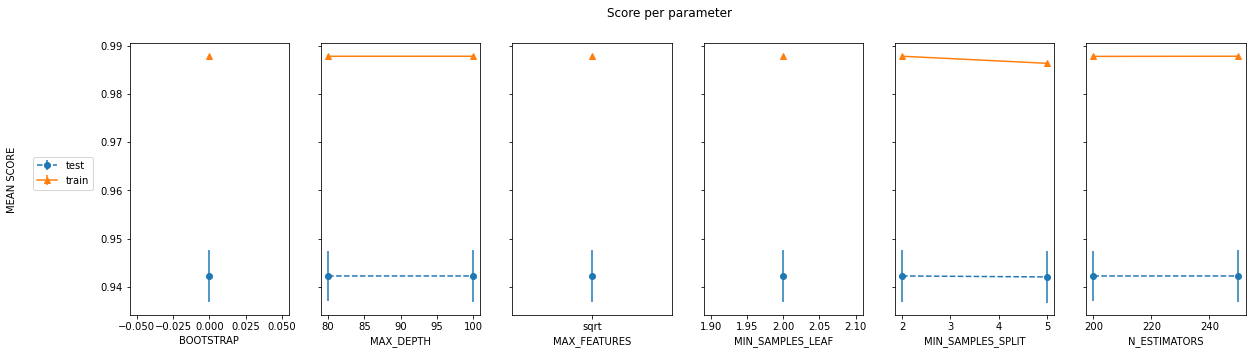

In [24]:
plot_search_results(result_grd, search='GridSearchCV')
plt.savefig('fig/11_grid_search.png')

From the previous plot, we can visualize how was the performance of the model (MEAN SCORE) for each value that each parameter adopted.